In [20]:
import pandas as pd
import numpy as np
from geopy.distance import geodesic
from scipy.optimize import linear_sum_assignment
from collections import deque, defaultdict
import matplotlib.pyplot as plt

# Data Processing

In [450]:
before2009 = pd.read_csv('SF_FDplusElev_data_before_2009.csv')
after2009 = pd.read_csv('SF_FDplusElev_data_after_2009.csv')
before2009.info()

C:\Users\15910\AppData\Local\Temp\ipykernel_46832\2400194598.py:2: DtypeWarning: Columns (6) have mixed types. Specify dtype option on import or set low_memory=False.
  after2009 = pd.read_csv('SF_FDplusElev_data_after_2009.csv')


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2047016 entries, 0 to 2047015
Data columns (total 10 columns):
 #   Column                  Dtype  
---  ------                  -----  
 0   Call Type               object 
 1   Call Final Disposition  object 
 2   Unit Type               object 
 3   Received DtTm           object 
 4   Response DtTm           object 
 5   On Scene DtTm           object 
 6   Call Type Group         float64
 7   Neighborhood  District  object 
 8   Location                object 
 9   elevation               float64
dtypes: float64(2), object(8)
memory usage: 156.2+ MB


In [3]:
after2009.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2140006 entries, 0 to 2140005
Data columns (total 10 columns):
 #   Column                  Dtype  
---  ------                  -----  
 0   Call Type               object 
 1   Call Final Disposition  object 
 2   Unit Type               object 
 3   Received DtTm           object 
 4   Response DtTm           object 
 5   On Scene DtTm           object 
 6   Call Type Group         object 
 7   Neighborhood  District  object 
 8   Location                object 
 9   elevation               float64
dtypes: float64(1), object(9)
memory usage: 163.3+ MB


In [4]:
after2009.head()

,Call Type,Call Final Disposition,Unit Type,Received DtTm,Response DtTm,On Scene DtTm,Call Type Group,Neighborhood District,Location,elevation
0,Alarms,Fire,CHIEF,09/05/2014 03:15:13 AM,09/05/2014 03:20:30 AM,09/05/2014 03:24:11 AM,Alarm,Haight Ashbury,"(37.7695711762103, -122.449920089485)",79.011720
1,Structure Fire,Fire,TRUCK,10/29/2015 03:39:06 PM,10/29/2015 03:40:55 PM,10/29/2015 03:43:21 PM,Alarm,Financial District/South Beach,"(37.7995314468258, -122.401240243673)",6.142661
2,Medical Incident,Code 2 Transport,PRIVATE,12/11/2014 09:02:07 AM,12/11/2014 09:06:19 AM,12/11/2014 09:20:16 AM,Potentially Life-Threatening,Castro/Upper Market,"(37.7668035178194, -122.440704687809)",139.991000
3,Medical Incident,Code 2 Transport,ENGINE,06/15/2014 02:04:57 AM,06/15/2014 02:12:55 AM,06/15/2014 02:24:55 AM,Non Life-threatening,South of Market,"(37.7756902570435, -122.408609057895)",6.119534
4,Outside Fire,Fire,ENGINE,09/20/2015 08:15:00 PM,09/20/2015 08:18:07 PM,04/25/2016 01:08:14 PM,Fire,Mission,"(37.7751470741622, -122.419255607214)",17.060550


In [5]:
before2009.head()

,Call Type,Call Final Disposition,Unit Type,Received DtTm,Response DtTm,On Scene DtTm,Call Type Group,Neighborhood District,Location,elevation
0,NaN,Other,ADMIN,01/25/2008 01:47:49 PM,04/25/2016 03:35:51 PM,04/25/2016 03:35:51 PM,NaN,Bayview Hunters Point,"(37.7406804919425, -122.396085269914)",5.234375
1,Alarms,Fire,CHIEF,07/17/2006 09:58:00 PM,07/17/2006 10:01:26 PM,04/25/2016 03:43:41 PM,NaN,Tenderloin,"(37.7859419706923, -122.408012730259)",16.836790
2,Alarms,Fire,CHIEF,02/10/2007 09:59:14 PM,02/10/2007 10:02:59 PM,02/10/2007 10:05:43 PM,NaN,Nob Hill,"(37.7908262425025, -122.418204055856)",69.543400
3,Other,Fire,AIRPORT,07/22/2007 02:16:50 PM,04/25/2016 03:38:28 PM,04/25/2016 03:38:28 PM,NaN,NaN,"(37.6168823239251, -122.384094238098)",9.083984
4,Alarms,Other,TRUCK,09/24/2008 12:21:05 PM,09/24/2008 12:24:35 PM,09/24/2008 12:26:14 PM,NaN,Western Addition,"(37.7871805642867, -122.424214337818)",63.992190


In [451]:
before2009.columns = after2009.columns = [
    'Call Type', 'Call Final Disposition', 'Unit Type',
    'Received DtTm', 'Response DtTm', 'On Scene DtTm',
    'Call Type Group', 'Neighborhood District', 'Location', 'Elevation'
]

In [452]:
datetime_format = '%m/%d/%Y %I:%M:%S %p'

for df in [before2009, after2009]:
    df['Received DtTm'] = pd.to_datetime(df['Received DtTm'], format=datetime_format, errors='coerce')
    df['Response DtTm'] = pd.to_datetime(df['Response DtTm'], format=datetime_format, errors='coerce')
    df['On Scene DtTm'] = pd.to_datetime(df['On Scene DtTm'], format=datetime_format, errors='coerce')

print(f"Before 2009 invalid Received DtTm count: {before2009['Received DtTm'].isna().sum()}")
print(f"After 2009 invalid Received DtTm count: {after2009['Received DtTm'].isna().sum()}")

Before 2009 invalid Received DtTm count: 0
After 2009 invalid Received DtTm count: 0


In [453]:
for df in [before2009, after2009]:
    df['Location_clean'] = df['Location'].str.strip('()')
    df[['Lat', 'Lon']] = df['Location_clean'].str.split(',', expand=True).astype(float)

print(f"Before 2009 invalid locations: {before2009['Lat'].isna().sum()}")
print(f"After 2009 invalid locations: {after2009['Lat'].isna().sum()}")

Before 2009 invalid locations: 0
After 2009 invalid locations: 0


In [454]:
df = pd.concat([before2009, after2009], ignore_index=True)

In [455]:
df = df[df['Call Type'].notna()].copy()
df = df.drop_duplicates().copy().reset_index(drop=True)

In [456]:
df = df[(df['Received DtTm'].notna()) & (df['Lat'].notna()) & (df['Lon'].notna())].copy()

In [457]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4151317 entries, 0 to 4151316
Data columns (total 13 columns):
 #   Column                  Dtype         
---  ------                  -----         
 0   Call Type               object        
 1   Call Final Disposition  object        
 2   Unit Type               object        
 3   Received DtTm           datetime64[ns]
 4   Response DtTm           datetime64[ns]
 5   On Scene DtTm           datetime64[ns]
 6   Call Type Group         object        
 7   Neighborhood District   object        
 8   Location                object        
 9   Elevation               float64       
 10  Location_clean          object        
 11  Lat                     float64       
 12  Lon                     float64       
dtypes: datetime64[ns](3), float64(3), object(7)
memory usage: 411.7+ MB


In [76]:
df.to_csv('SF_FDplusElev_cleaned.csv', index=False)

In [13]:
facilities = pd.read_csv('SF_Facilities.csv')
facilities.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 79 entries, 0 to 78
Data columns (total 15 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   facility_id               79 non-null     int64  
 1   common_name               79 non-null     object 
 2   address                   79 non-null     object 
 3   city                      79 non-null     object 
 4   zip_code                  79 non-null     int64  
 5   block_lot                 78 non-null     object 
 6   owned_leased              79 non-null     object 
 7   dept_id_for_jurisdiction  79 non-null     int64  
 8   jurisdiction              79 non-null     object 
 9   gross_sq_ft               64 non-null     float64
 10  longitude                 79 non-null     float64
 11  latitude                  79 non-null     float64
 12  supervisor_district       79 non-null     int64  
 13  city_tenants              0 non-null      float64
 14  land_id     

In [14]:
facilities.head()

,facility_id,common_name,address,city,zip_code,block_lot,owned_leased,dept_id_for_jurisdiction,jurisdiction,gross_sq_ft,longitude,latitude,supervisor_district,city_tenants,land_id
0,710,Fire Station #28,1814 Stockton St,San Francisco,94133,0077024,Own,38,Fire Department,9350.0,-122.409352,37.802548,3,NaN,338.0
1,702,Fire Station #2,1340 Powell St,San Francisco,94133,0160015,Own,38,Fire Department,16920.0,-122.409879,37.797034,3,NaN,337.0
2,695,Fire Station #13,530 Sansome St,San Francisco,94111,0206017,Own,38,Fire Department,18790.0,-122.401350,37.795519,3,NaN,336.0
3,724,Fire Station #41,1325 Leavenworth St,San Francisco,94109,0216003,Own,38,Fire Department,9600.0,-122.416495,37.793377,3,NaN,334.0
4,685,Fire Chief's Residence,870 Bush St,San Francisco,94108,0274010,Own,38,Fire Department,4500.0,-122.411592,37.789999,3,NaN,333.0


In [15]:
print("Unique Unit Type Groups:")
print(df['Unit Type'].value_counts())

Unique Unit Type Groups:
Unit Type
ENGINE            1628248
MEDIC             1271944
TRUCK              457972
CHIEF              306749
PRIVATE            225085
RESCUE CAPTAIN     145513
RESCUE SQUAD        77350
AIRPORT             19062
SUPPORT             14602
INVESTIGATION        4792
Name: count, dtype: int64


# Simulation based on Poisson Arrival & Spatial Distribution

In [440]:
df = pd.read_csv('SF_FDplusElev_cleaned.csv')

C:\Users\15910\AppData\Local\Temp\ipykernel_46832\1112105107.py:1: DtypeWarning: Columns (6) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv('SF_FDplusElev_cleaned.csv')


In [449]:
print("Unique Call Type Groups:")
print(df['Call Type'].value_counts())

Unique Call Type Groups:
Call Type
Medical Incident                   3078
Structure Fire                     2656
Alarms                              473
Traffic Collision                   173
Other                                87
Citizen Assist / Service Call        74
Outside Fire                         57
Administrative                       31
Water Rescue                         23
Electrical Hazard                    22
Vehicle Fire                         22
Odor (Strange / Unknown)             17
Gas Leak (Natural and LP Gases)      15
Fuel Spill                           13
Smoke Investigation (Outside)        13
Elevator / Escalator Rescue          12
HazMat                                6
Explosion                             3
Transfer                              3
High Angle Rescue                     2
Marine Fire                           1
Oil Spill                             1
Aircraft Emergency                    1
Assist Police                         1
Train

In [17]:
call_type_distribution = df['Call Type'].value_counts(normalize=True)
call_type_distribution

Call Type
Medical Incident                                0.638849
Structure Fire                                  0.136621
Alarms                                          0.106565
Traffic Collision                               0.039114
Other                                           0.015780
Citizen Assist / Service Call                   0.015241
Outside Fire                                    0.011398
Administrative                                  0.007232
Vehicle Fire                                    0.004863
Water Rescue                                    0.004313
Gas Leak (Natural and LP Gases)                 0.003536
Odor (Strange / Unknown)                        0.002874
Electrical Hazard                               0.002713
Elevator / Escalator Rescue                     0.002557
Smoke Investigation (Outside)                   0.002148
Fuel Spill                                      0.001190
Transfer                                        0.001011
HazMat               

total days: 6043
Received_Hour
0     21.684097
1     20.591594
2     19.210491
3     14.934139
4     12.473440
5     12.427106
6     15.040377
7     20.179712
8     26.692371
9     32.339070
10    35.767500
11    37.503889
12    37.609300
13    38.534503
14    38.937945
15    38.588449
16    37.905180
17    38.108886
18    37.210326
19    35.361244
20    33.278008
21    30.541122
22    27.652325
23    24.391858
dtype: float64


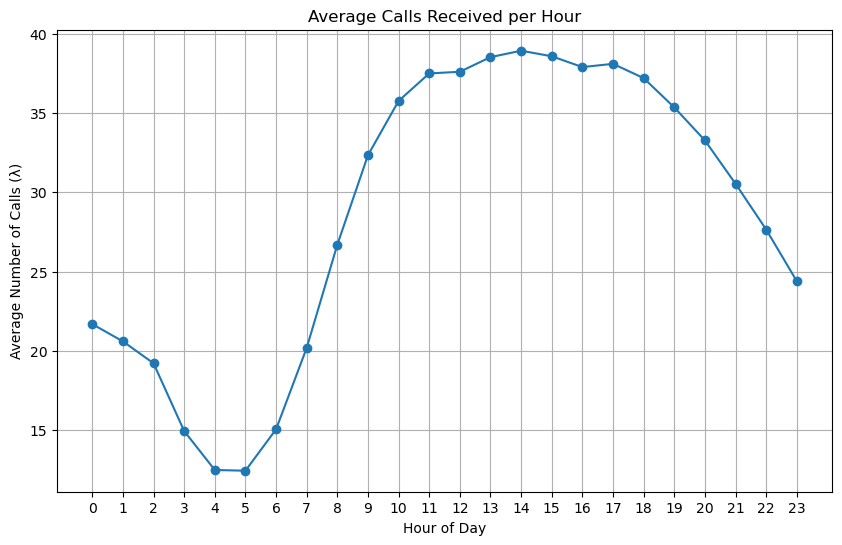

In [458]:
df['Received_Hour'] = df['Received DtTm'].dt.hour
df['Received_Date'] = df['Received DtTm'].dt.date

total_days = df['Received_Date'].nunique()
print(f"total days: {total_days}")

hourly_call_counts = df.groupby('Received_Hour').size().reindex(range(24), fill_value=0)

lambda_per_hour = hourly_call_counts / total_days

print(lambda_per_hour)

plt.figure(figsize=(10,6))
plt.plot(lambda_per_hour.index, lambda_per_hour.values, marker='o')
plt.title('Average Calls Received per Hour')
plt.xlabel('Hour of Day')
plt.ylabel('Average Number of Calls (λ)')
plt.grid(True)
plt.xticks(range(24))
plt.savefig('temporal.png', dpi=300, format='png')
plt.show()

Neighborhood District
Tenderloin                        0.130183
South of Market                   0.094096
Mission                           0.091198
Financial District/South Beach    0.066544
Bayview Hunters Point             0.054409
Sunset/Parkside                   0.039865
Western Addition                  0.037321
Nob Hill                          0.033127
Outer Richmond                    0.027424
Hayes Valley                      0.024714
Castro/Upper Market               0.023545
West of Twin Peaks                0.022907
Chinatown                         0.021819
North Beach                       0.021464
Pacific Heights                   0.020887
Excelsior                         0.020277
Bernal Heights                    0.019183
Marina                            0.018906
Potrero Hill                      0.018388
Inner Sunset                      0.016493
Russian Hill                      0.015949
Haight Ashbury                    0.015106
Outer Mission                   

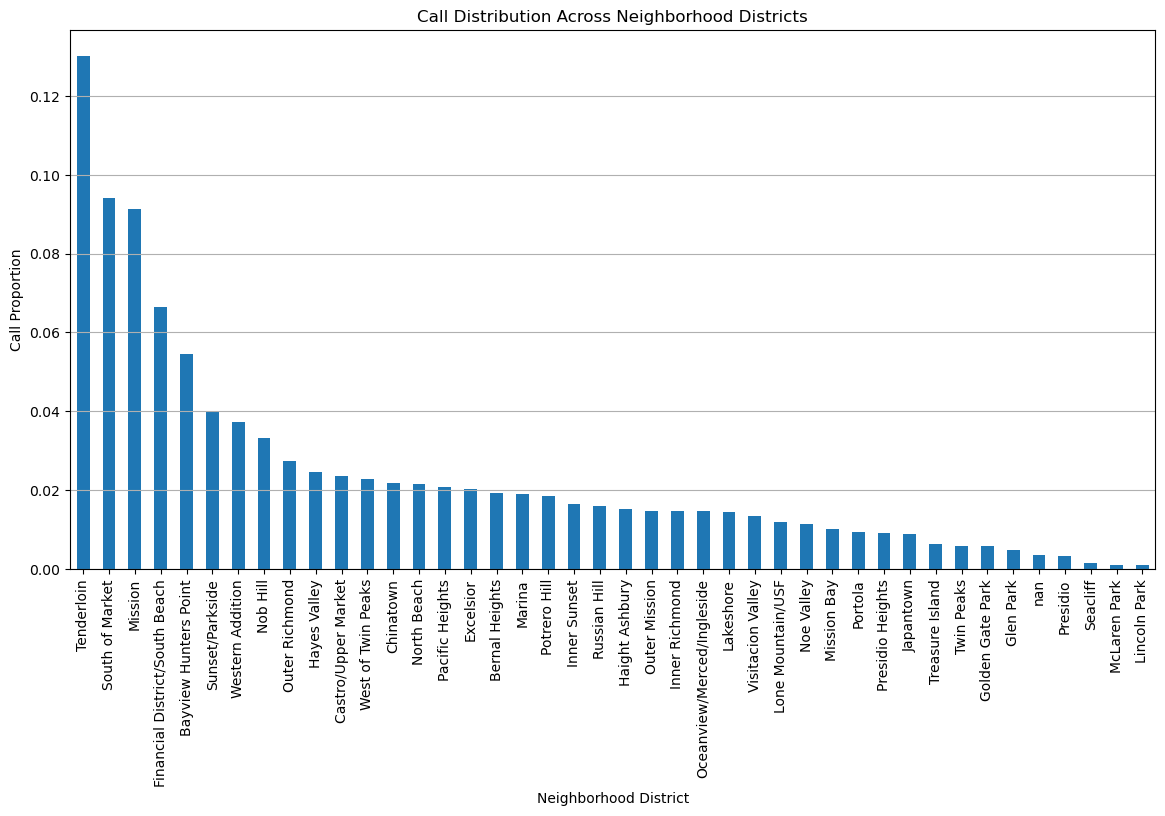

In [459]:
district_call_counts = df['Neighborhood District'].value_counts(dropna=False)

district_call_prob = district_call_counts / district_call_counts.sum()

print(district_call_prob)

plt.figure(figsize=(14,7))
district_call_prob.sort_values(ascending=False).plot(kind='bar')
plt.title('Call Distribution Across Neighborhood Districts')
plt.xlabel('Neighborhood District')
plt.ylabel('Call Proportion')
plt.xticks(rotation=90)
plt.grid(True, axis='y')
plt.savefig('spatial.png', dpi=300, format='png')
plt.show()

In [23]:
global_lat_mean = df['Lat'].mean()
global_lon_mean = df['Lon'].mean()

In [24]:
global_lat_mean = df['Lat'].mean()
global_lon_mean = df['Lon'].mean()
district_points_pool = {}

for district_name in district_call_prob.index:
    district_data = df[df['Neighborhood District'] == district_name][['Lat', 'Lon']]
    if not district_data.empty:
        district_points_pool[district_name] = district_data.reset_index(drop=True)
    else:
        district_points_pool[district_name] = None

In [25]:
simulation_days = 30
calls_list = []
simulation_start = pd.Timestamp('2023-01-01 00:00:00')

for day in range(simulation_days):
    for hour in range(24):
        hour_start = simulation_start + pd.Timedelta(days=day, hours=hour)
        
        lam = lambda_per_hour.loc[hour]
        num_calls = np.random.poisson(lam)

        for _ in range(num_calls):
            seconds_into_hour = np.random.randint(0, 3600)
            call_time = hour_start + pd.Timedelta(seconds=seconds_into_hour)

            district = np.random.choice(district_call_prob.index, p=district_call_prob.values)

            if pd.notna(district):
                pool = district_points_pool.get(district)
                if pool is not None and not pool.empty:
                    sample_point = pool.sample(1)
                    lat = sample_point['Lat'].values[0]
                    lon = sample_point['Lon'].values[0]
                else:
                    lat = global_lat_mean
                    lon = global_lon_mean
            else:
                lat = global_lat_mean
                lon = global_lon_mean

            call_type = np.random.choice(call_type_distribution.index, p=call_type_distribution.values)

            calls_list.append({
                'Call ID': len(calls_list),
                'Received DtTm': call_time,
                'Neighborhood District': district,
                'Lat': lat,
                'Lon': lon,
                'Call Type': call_type
            })

simulated_calls = pd.DataFrame(calls_list)
simulated_calls = simulated_calls.sort_values('Received DtTm').reset_index(drop=True)

In [320]:
simulated_calls.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20779 entries, 0 to 20778
Data columns (total 6 columns):
 #   Column                 Non-Null Count  Dtype         
---  ------                 --------------  -----         
 0   Call ID                20779 non-null  int64         
 1   Received DtTm          20779 non-null  datetime64[ns]
 2   Neighborhood District  20694 non-null  object        
 3   Lat                    20779 non-null  float64       
 4   Lon                    20779 non-null  float64       
 5   Call Type              20779 non-null  object        
dtypes: datetime64[ns](1), float64(2), int64(1), object(2)
memory usage: 974.1+ KB


In [346]:
simulated_calls = simulated_calls.sort_values('Received DtTm').reset_index(drop=True)
simulated_calls.to_csv('simulated_calls.csv', index=False)

In [347]:
simulated_calls = pd.read_csv('simulated_calls.csv')
simulated_calls['Received DtTm'] = pd.to_datetime(simulated_calls['Received DtTm'], errors='coerce')
simulated_calls = simulated_calls.sort_values('Received DtTm').reset_index(drop=True)

In [369]:
quake_center = (37.75, -122.45)
quake_calls = []
quake_count = 2000
quake_time = pd.Timestamp('2023-01-03 10:00:00')
for i in range(quake_count):
    lat = quake_center[0] + np.random.uniform(-0.02, 0.02)
    lon = quake_center[1] + np.random.uniform(-0.02, 0.02)
    quake_calls.append({
        'Call ID': len(simulated_calls) + i,
        'Received DtTm': quake_time + pd.Timedelta(seconds=np.random.randint(0, 12*3600)),
        'Neighborhood District': 'Excelsior',
        'Lat': lat, 'Lon': lon,
        'Call Type': 'Structure Fire'
    })
surge_simulated_calls = pd.concat([simulated_calls, pd.DataFrame(quake_calls)], ignore_index=True)
surge_simulated_calls.sort_values('Received DtTm', inplace=True)
surge_simulated_calls.reset_index(drop=True, inplace=True)

In [370]:
surge_simulated_calls.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 22779 entries, 0 to 22778
Data columns (total 6 columns):
 #   Column                 Non-Null Count  Dtype         
---  ------                 --------------  -----         
 0   Call ID                22779 non-null  int64         
 1   Received DtTm          22779 non-null  datetime64[ns]
 2   Neighborhood District  22694 non-null  object        
 3   Lat                    22779 non-null  float64       
 4   Lon                    22779 non-null  float64       
 5   Call Type              22779 non-null  object        
dtypes: datetime64[ns](1), float64(2), int64(1), object(2)
memory usage: 1.0+ MB


In [371]:
surge_simulated_calls.to_csv('surge_simulated_calls.csv', index=False)

# Fire Station

In [31]:
facilities = pd.read_csv('SF_Facilities.csv')

In [32]:
fire_stations = facilities[facilities['common_name'].str.contains('Fire Station', case=False)]
fire_stations = fire_stations[['facility_id', 'common_name', 'longitude', 'latitude']].reset_index(drop=True)
fire_stations.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 45 entries, 0 to 44
Data columns (total 4 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   facility_id  45 non-null     int64  
 1   common_name  45 non-null     object 
 2   longitude    45 non-null     float64
 3   latitude     45 non-null     float64
dtypes: float64(2), int64(1), object(1)
memory usage: 1.5+ KB


In [ ]:
engine_truck_calls = df[df['Unit Type'].isin(['ENGINE', 'TRUCK'])]

calltype_by_engine_truck = engine_truck_calls['Call Type'].value_counts()

print(calltype_by_engine_truck)

# Dispatch

In [415]:
import pandas as pd
import numpy as np
from collections import deque, defaultdict
from geopy.distance import geodesic
from scipy.optimize import linear_sum_assignment

# === PARAMETERS & MAPPINGS ===
EMERGENCY_SPEED = 11.1    # m/s
alpha = 1               # 优先级权重
beta  = 0.2               # 等待权重
DISTRICT_SURGE_TRIGGER = 10  # pending calls 超过此值触发 Surge
DISTRICT_SURGE_EXIT    = 5  # pending calls <= 此值退出 Surge

service_time_mapping = {
    'Structure Fire':100, 'Explosion':90, 'Outside Fire':90, 'Vehicle Fire':90,
    'Marine Fire':90, 'Medical Incident':30, 'Traffic Collision':30,
    'Extrication / Entrapped (Machinery, Vehicle)':45, 'Water Rescue':60,
    'HazMat':60, 'Gas Leak (Natural and LP Gases)':45, 'Electrical Hazard':20,
    'Smoke Investigation (Outside)':20, 'Assist Police':20, 'Alarms':20,
    'Suspicious Package':30, 'Odor (Strange / Unknown)':20,
    'Train / Rail Incident':45, 'Train / Rail Fire':45,
    'Confined Space / Structure Collapse':60, 'High Angle Rescue':60,
    'Other':30, 'Administrative':15, 'Transfer':20,
    'Industrial Accidents':45, 'Watercraft in Distress':45,
    'Mutual Aid / Assist Outside Agency':30,
    'Elevator / Escalator Rescue':20, 'Lightning Strike (Investigation)':20,
    'Fuel Spill':30
}
default_service_time = 30

priority_mapping = {
    'Structure Fire':1, 'Explosion':1, 'Aircraft Emergency':1,
    'Confined Space / Structure Collapse':2,
    'Extrication / Entrapped (Machinery, Vehicle)':2, 'High Angle Rescue':2,
    'Medical Incident':2, 'Outside Fire':3, 'Vehicle Fire':3,
    'Marine Fire':3, 'Water Rescue':3, 'Smoke Investigation (Outside)':3,
    'HazMat':3, 'Gas Leak (Natural and LP Gases)':3, 'Electrical Hazard':4,
    'Watercraft in Distress':4, 'Train / Rail Incident':4,
    'Train / Rail Fire':4, 'Traffic Collision':4,
    'Industrial Accidents':4, 'Assist Police':5,
    'Mutual Aid / Assist Outside Agency':5, 'Citizen Assist / Service Call':5,
    'Suspicious Package':5, 'Odor (Strange / Unknown)':5, 'Alarms':6,
    'Administrative':7, 'Transfer':7, 'Other':7,
    'Lightning Strike (Investigation)':7, 'Fuel Spill':7,
    'Elevator / Escalator Rescue':7
}
default_priority = 8

max_wait_mapping = {
    'Structure Fire':8, 'Explosion':8, 'Outside Fire':10, 'Vehicle Fire':10,
    'Marine Fire':10, 'Medical Incident':6, 'Traffic Collision':8,
    'Extrication / Entrapped (Machinery, Vehicle)':10, 'Water Rescue':12,
    'HazMat':15
}
default_max_wait = 30

# === LOAD & PREPARE STATION STATUS ===
# Example: load stations and assume 2 engines per station
facilities = pd.read_csv('SF_Facilities.csv')
fires = facilities[facilities['common_name'].str.contains('Fire Station')]
station_status = {}
for _, r in fires.iterrows():
    sid = int(r['facility_id'])
    loc = (r['latitude'], r['longitude'])
    station_status[sid] = {
        'available_ENGINE': 4,
        'location': loc
    }

# === RESET ALL GLOBAL STATE ===
busy_units = []    # 正在服务的车辆
dispatch_records = []
pending_calls_per_district = defaultdict(deque)
surge_mode_per_district   = defaultdict(lambda: False)
surge_deployed = set()
deployments = []   # Surge 部署中车辆
available_units = []

# 初始化可用车辆池
uid = 0
for sid, info in station_status.items():
    for _ in range(info['available_ENGINE']):
        available_units.append({
            'unit_id': uid,
            'station_id': sid,
            'location': info['location']
        })
        uid += 1

# === LOAD & PREPARE CALLS ===
df = pd.read_csv('surge_simulated_calls.csv')
df['Received DtTm'] = pd.to_datetime(df['Received DtTm'], errors='coerce')
df = df[df['Received DtTm'] < pd.Timestamp('2023-01-08')]
df = df.sort_values('Received DtTm').reset_index(drop=True)
# reversed priority for cost computation
df['priority_score'] = 8 - df['Call Type'].map(priority_mapping).fillna(default_priority)
upcoming_calls = deque(df.to_dict('records'))

# === DISPATCH FUNCTION ===
def dispatch_unit_to_call(unit, call, mode):
    if mode == 'failed':
        dispatch_records.append({
            'Call ID': call['call_id'],
            'Received DtTm': call['received_time'],
            'Assigned Station ID': None,
            'Dispatch Mode': 'failed',
            'Response Time (min)': np.nan,
            'Total Busy Time (min)': np.nan,
            'Priority': call['priority_score'],
            'District': call['district'],
            'Wait Time (min)': call['waiting_time'],
            'Max Wait (min)': max_wait_mapping.get(call['call_type'], default_max_wait)
        })
        return

    # 正常 or surge 派车
    available_units.remove(unit)
    d_m = geodesic(unit['location'], call['location']).meters
    travel_min = d_m/EMERGENCY_SPEED/60
    svc = service_time_mapping.get(call['call_type'], default_service_time)
    busy_min = 2*travel_min + svc
    free_time = call['received_time'] + pd.Timedelta(minutes=busy_min)

    # 完成后位置
    if mode == 'surge':
        next_loc = call['location']
    else:
        next_loc = station_status[unit['station_id']]['location']

    busy_units.append({
        'unit_id': unit['unit_id'],
        'station_id': unit['station_id'],
        'expected_free_time': free_time,
        'location': next_loc
    })
    dispatch_records.append({
        'Call ID': call['call_id'],
        'Received DtTm': call['received_time'],
        'Assigned Station ID': unit['station_id'],
        'Dispatch Mode': mode,
        'Response Time (min)': travel_min,
        'Total Busy Time (min)': busy_min,
        'Priority': call['priority_score'],
        'District': call['district'],
        'Wait Time (min)': call['waiting_time'],
        'Max Wait (min)': max_wait_mapping.get(call['call_type'], default_max_wait)
    })
    # 移除 pending
    pending_calls_per_district[call['district']] = deque(
        [c for c in pending_calls_per_district[call['district']]
         if c['call_id'] != call['call_id']]
    )

# === MAIN SIMULATION LOOP ===
current_time = df['Received DtTm'].min()
step = 0
pending_excelsior = []
time_steps = []

while (upcoming_calls
       or any(pending_calls_per_district.values())
       or busy_units
       or deployments):

    # 0) 更新部署中车辆 en-route 位置
    for dep in deployments[:]:
        if current_time >= dep['end_time']:
            dep['unit']['location'] = dep['center_loc']
            deployments.remove(dep)
            available_units.append(dep['unit'])
        else:
            frac = ((current_time - dep['start_time']).total_seconds() /
                    (dep['end_time'] - dep['start_time']).total_seconds())
            lat0, lon0 = dep['start_loc']
            lat1, lon1 = dep['center_loc']
            dep['unit']['location'] = (lat0 + frac*(lat1-lat0),
                                       lon0 + frac*(lon1-lon0))

    # 1) 释放 busy_units
    done = [u for u in busy_units if u['expected_free_time'] <= current_time]
    for u in done:
        busy_units.remove(u)
        available_units.append({
            'unit_id': u['unit_id'],
            'station_id': u['station_id'],
            'location': u['location']
        })

    # 2) 新呼叫入队
    while upcoming_calls and upcoming_calls[0]['Received DtTm'] <= current_time:
        r = upcoming_calls.popleft()
        if pd.isna(r['Neighborhood District']):
            continue
        pending_calls_per_district[r['Neighborhood District']].append({
            'call_id': r['Call ID'],
            'received_time': r['Received DtTm'],
            'call_type': r['Call Type'],
            'priority_score': r['priority_score'],
            'location': (r['Lat'], r['Lon']),
            'district': r['Neighborhood District'],
            'waiting_time': 0
        })

    # 3) 增加等待 & 过期剔除
    for dist, queue in list(pending_calls_per_district.items()):
        new_q = deque()
        for call in queue:
            call['waiting_time'] += 5
            mw = max_wait_mapping.get(call['call_type'], default_max_wait)
            if call['waiting_time'] > mw:
                dispatch_unit_to_call(None, call, mode='failed')
            else:
                new_q.append(call)
        pending_calls_per_district[dist] = new_q

    # 4) Surge 检测 & 部署
    for dist, queue in pending_calls_per_district.items():
        pc = len(queue)
        # 触发/退出
        if not surge_mode_per_district[dist] and pc > DISTRICT_SURGE_TRIGGER:
            surge_mode_per_district[dist] = True
            print(dist)
            print(pc)
        elif surge_mode_per_district[dist] and pc <= DISTRICT_SURGE_EXIT:
            surge_mode_per_district[dist] = False
            print(dist)
            print(pc)

        # 首次进入 Surge：部署除每站留一车外所有空闲单位
        if surge_mode_per_district[dist] and dist not in surge_deployed and queue:
            surge_deployed.add(dist)
            center = queue[0]['location']
            leave_one = defaultdict(bool)
            to_deploy = []
            for u in available_units:
                sid = u['station_id']
                if not leave_one[sid]:
                    leave_one[sid] = True
                else:
                    to_deploy.append(u)
            for u in to_deploy:
                available_units.remove(u)
                d_m = geodesic(u['location'], center).meters
                t_min = d_m / EMERGENCY_SPEED / 60
                deployments.append({
                    'unit': u,
                    'start_time': current_time,
                    'end_time':   current_time + pd.Timedelta(minutes=t_min),
                    'start_loc':  u['location'],
                    'center_loc': center
                })

    # 5) Dispatch: 全局 Surge 或 本地 Greedy
    if any(surge_mode_per_district.values()):
        # 全局 assignment
        all_calls = [c for q in pending_calls_per_district.values() for c in q]
        all_units = available_units[:]
        n_u, n_c = len(all_units), len(all_calls)
        if n_u > 0 and n_c > 0:
            cost = np.zeros((n_u, n_c))
            for ui, u in enumerate(all_units):
                for ci, c in enumerate(all_calls):
                    d_m = geodesic(u['location'], c['location']).meters
                    t_m = d_m / EMERGENCY_SPEED / 60
                    cost[ui,ci] = t_m - alpha*c['priority_score'] - beta*c['waiting_time']
            ri, ci = linear_sum_assignment(cost)
            for ui, ci in zip(ri, ci):
                if cost[ui,ci] < np.inf:
                    dispatch_unit_to_call(all_units[ui], all_calls[ci], mode='surge')
    else:
        # 本地跨区 Greedy
        calls = [c for q in pending_calls_per_district.values() for c in q]
        calls = sorted(calls, key=lambda x:(x['priority_score'], -x['waiting_time']))
        for call in calls:
            if not available_units:
                break
            best_u, best_cost = None, float('inf')
            for u in available_units:
                d_m = geodesic(u['location'], call['location']).meters
                t_m = d_m / EMERGENCY_SPEED / 60
                cst = t_m - alpha*call['priority_score'] - beta*call['waiting_time']
                if cst < best_cost:
                    best_cost, best_u = cst, u
            if best_u:
                dispatch_unit_to_call(best_u, call, mode='normal')

    # 6) 记录 Excelsior pending & 时间推进
    pending_excelsior.append(len(pending_calls_per_district.get('Excelsior', [])))
    time_steps.append(step)
    step += 1
    current_time += pd.Timedelta(seconds=300)

# === METRICS REPORTING ===
df_all = pd.DataFrame(dispatch_records)
df_calls = df_all[df_all['Call ID'].notnull()].copy()
df_unique = df_calls.groupby('Call ID', as_index=False).tail(1)
df_unique['Failed'] = df_unique['Dispatch Mode']=='failed'
total_calls        = len(df)
failed_dispatches  = df_unique['Failed'].sum()
print(f"Overall failure rate: {failed_dispatches/total_calls*100:.2f}%\n")
print("Failure Rate by Dispatch Mode:")
print(df_unique.groupby('Dispatch Mode')['Failed'].mean().mul(100).round(2), "\n")
df_unique['Original Priority'] = 8 - df_unique['Priority']
prio = df_unique.groupby('Original Priority').agg(
    Total_Calls = ('Call ID','size'),
    Failed_Calls= ('Failed','sum')
).reset_index().sort_values('Original Priority')
prio['Solved_Calls'] = prio['Total_Calls'] - prio['Failed_Calls']
prio['Solved_%']     = (prio['Solved_Calls']/prio['Total_Calls']*100).round(2)
prio['Failed_%']     = (prio['Failed_Calls']/prio['Total_Calls']*100).round(2)
print("Failure/Solved % by Original Priority:")
print(prio[['Original Priority','Total_Calls','Solved_Calls','Solved_%','Failed_%']])


Excelsior
17
Excelsior
0
Overall failure rate: 14.66%

Failure Rate by Dispatch Mode:
Dispatch Mode
failed    100.0
normal      0.0
surge       0.0
Name: Failed, dtype: float64 

Failure/Solved % by Original Priority:
   Original Priority  Total_Calls  Solved_Calls  Solved_%  Failed_%
0                1.0         2660          1859     69.89     30.11
1                2.0         3063          2898     94.61      5.39
2                3.0          137           133     97.08      2.92
3                4.0          195           183     93.85      6.15
4                5.0           92            92    100.00      0.00
5                6.0          469           459     97.87      2.13
6                7.0          145           142     97.93      2.07
7                8.0            1             1    100.00      0.00


In [444]:
EMERGENCY_SPEED = 11.1
alpha = 
beta  = 0.2
DISTRICT_SURGE_TRIGGER = 10000 
DISTRICT_SURGE_EXIT    = 5

service_time_mapping = {
    'Structure Fire':100, 'Explosion':90, 'Outside Fire':90, 'Vehicle Fire':90,
    'Marine Fire':90, 'Medical Incident':30, 'Traffic Collision':30,
    'Extrication / Entrapped (Machinery, Vehicle)':45, 'Water Rescue':60,
    'HazMat':60, 'Gas Leak (Natural and LP Gases)':45, 'Electrical Hazard':20,
    'Smoke Investigation (Outside)':20, 'Assist Police':20, 'Alarms':20,
    'Suspicious Package':30, 'Odor (Strange / Unknown)':20,
    'Train / Rail Incident':45, 'Train / Rail Fire':45,
    'Confined Space / Structure Collapse':60, 'High Angle Rescue':60,
    'Other':30, 'Administrative':15, 'Transfer':20,
    'Industrial Accidents':45, 'Watercraft in Distress':45,
    'Mutual Aid / Assist Outside Agency':30,
    'Elevator / Escalator Rescue':20, 'Lightning Strike (Investigation)':20,
    'Fuel Spill':30
}
default_service_time = 30

priority_mapping = {
    'Structure Fire':1, 'Explosion':1, 'Aircraft Emergency':1,
    'Confined Space / Structure Collapse':2,
    'Extrication / Entrapped (Machinery, Vehicle)':2, 'High Angle Rescue':2,
    'Medical Incident':2, 'Outside Fire':3, 'Vehicle Fire':3,
    'Marine Fire':3, 'Water Rescue':3, 'Smoke Investigation (Outside)':3,
    'HazMat':3, 'Gas Leak (Natural and LP Gases)':3, 'Electrical Hazard':4,
    'Watercraft in Distress':4, 'Train / Rail Incident':4,
    'Train / Rail Fire':4, 'Traffic Collision':4,
    'Industrial Accidents':4, 'Assist Police':5,
    'Mutual Aid / Assist Outside Agency':5, 'Citizen Assist / Service Call':5,
    'Suspicious Package':5, 'Odor (Strange / Unknown)':5, 'Alarms':6,
    'Administrative':7, 'Transfer':7, 'Other':7,
    'Lightning Strike (Investigation)':7, 'Fuel Spill':7,
    'Elevator / Escalator Rescue':7
}
default_priority = 8

max_wait_mapping = {
    'Structure Fire':8, 'Explosion':8, 'Outside Fire':10, 'Vehicle Fire':10,
    'Marine Fire':10, 'Medical Incident':6, 'Traffic Collision':8,
    'Extrication / Entrapped (Machinery, Vehicle)':10, 'Water Rescue':12,
    'HazMat':15
}
default_max_wait = 30

facilities = pd.read_csv('SF_Facilities.csv')
fires = facilities[facilities['common_name'].str.contains('Fire Station')]
station_status = {}
for _, r in fires.iterrows():
    sid = int(r['facility_id'])
    loc = (r['latitude'], r['longitude'])
    station_status[sid] = {
        'available_ENGINE': 4,
        'location': loc
    }

busy_units = []
dispatch_records = []
pending_calls_per_district = defaultdict(deque)
surge_mode_per_district   = defaultdict(lambda: False)
surge_deployed = set()
deployments = []
available_units = []

uid = 0
for sid, info in station_status.items():
    for _ in range(info['available_ENGINE']):
        available_units.append({
            'unit_id': uid,
            'station_id': sid,
            'location': info['location']
        })
        uid += 1

df = pd.read_csv('surge_simulated_calls.csv')
df['Received DtTm'] = pd.to_datetime(df['Received DtTm'], errors='coerce')
df = df[df['Received DtTm'] < pd.Timestamp('2023-01-08')]
df = df.sort_values('Received DtTm').reset_index(drop=True)
# reversed priority for cost computation
df['priority_score'] = 8 - df['Call Type'].map(priority_mapping).fillna(default_priority)
upcoming_calls = deque(df.to_dict('records'))

def dispatch_unit_to_call(unit, call, mode):
    if mode == 'failed':
        dispatch_records.append({
            'Call ID': call['call_id'],
            'Received DtTm': call['received_time'],
            'Assigned Station ID': None,
            'Dispatch Mode': 'failed',
            'Response Time (min)': np.nan,
            'Total Busy Time (min)': np.nan,
            'Priority': call['priority_score'],
            'District': call['district'],
            'Wait Time (min)': call['waiting_time'],
            'Max Wait (min)': max_wait_mapping.get(call['call_type'], default_max_wait)
        })
        return

    available_units.remove(unit)
    d_m = geodesic(unit['location'], call['location']).meters
    travel_min = d_m/EMERGENCY_SPEED/60
    svc = service_time_mapping.get(call['call_type'], default_service_time)
    busy_min = 2*travel_min + svc
    free_time = call['received_time'] + pd.Timedelta(minutes=busy_min)

    if mode == 'surge':
        next_loc = call['location']
    else:
        next_loc = station_status[unit['station_id']]['location']

    busy_units.append({
        'unit_id': unit['unit_id'],
        'station_id': unit['station_id'],
        'expected_free_time': free_time,
        'location': next_loc
    })
    dispatch_records.append({
        'Call ID': call['call_id'],
        'Received DtTm': call['received_time'],
        'Assigned Station ID': unit['station_id'],
        'Dispatch Mode': mode,
        'Response Time (min)': travel_min,
        'Total Busy Time (min)': busy_min,
        'Priority': call['priority_score'],
        'District': call['district'],
        'Wait Time (min)': call['waiting_time'],
        'Max Wait (min)': max_wait_mapping.get(call['call_type'], default_max_wait)
    })
    pending_calls_per_district[call['district']] = deque(
        [c for c in pending_calls_per_district[call['district']]
         if c['call_id'] != call['call_id']]
    )

current_time = df['Received DtTm'].min()
step = 0
pending_excelsior = []
time_steps = []

while (upcoming_calls
       or any(pending_calls_per_district.values())
       or busy_units
       or deployments):

    for dep in deployments[:]:
        if current_time >= dep['end_time']:
            dep['unit']['location'] = dep['center_loc']
            deployments.remove(dep)
            available_units.append(dep['unit'])
        else:
            frac = ((current_time - dep['start_time']).total_seconds() /
                    (dep['end_time'] - dep['start_time']).total_seconds())
            lat0, lon0 = dep['start_loc']
            lat1, lon1 = dep['center_loc']
            dep['unit']['location'] = (lat0 + frac*(lat1-lat0),
                                       lon0 + frac*(lon1-lon0))

    done = [u for u in busy_units if u['expected_free_time'] <= current_time]
    for u in done:
        busy_units.remove(u)
        available_units.append({
            'unit_id': u['unit_id'],
            'station_id': u['station_id'],
            'location': u['location']
        })

    while upcoming_calls and upcoming_calls[0]['Received DtTm'] <= current_time:
        r = upcoming_calls.popleft()
        if pd.isna(r['Neighborhood District']):
            continue
        pending_calls_per_district[r['Neighborhood District']].append({
            'call_id': r['Call ID'],
            'received_time': r['Received DtTm'],
            'call_type': r['Call Type'],
            'priority_score': r['priority_score'],
            'location': (r['Lat'], r['Lon']),
            'district': r['Neighborhood District'],
            'waiting_time': 0
        })

    for dist, queue in list(pending_calls_per_district.items()):
        new_q = deque()
        for call in queue:
            call['waiting_time'] += 5
            mw = max_wait_mapping.get(call['call_type'], default_max_wait)
            if call['waiting_time'] > mw:
                dispatch_unit_to_call(None, call, mode='failed')
            else:
                new_q.append(call)
        pending_calls_per_district[dist] = new_q

    for dist, queue in pending_calls_per_district.items():
        pc = len(queue)
        if not surge_mode_per_district[dist] and pc > DISTRICT_SURGE_TRIGGER:
            surge_mode_per_district[dist] = True
            print(dist)
            print(pc)
        elif surge_mode_per_district[dist] and pc <= DISTRICT_SURGE_EXIT:
            surge_mode_per_district[dist] = False
            print(dist)
            print(pc)

        if surge_mode_per_district[dist] and dist not in surge_deployed and queue:
            surge_deployed.add(dist)
            center = queue[0]['location']
            leave_one = defaultdict(bool)
            to_deploy = []
            for u in available_units:
                sid = u['station_id']
                if not leave_one[sid]:
                    leave_one[sid] = True
                else:
                    to_deploy.append(u)
            for u in to_deploy:
                available_units.remove(u)
                d_m = geodesic(u['location'], center).meters
                t_min = d_m / EMERGENCY_SPEED / 60
                deployments.append({
                    'unit': u,
                    'start_time': current_time,
                    'end_time':   current_time + pd.Timedelta(minutes=t_min),
                    'start_loc':  u['location'],
                    'center_loc': center
                })

    if any(surge_mode_per_district.values()):
        all_calls = [c for q in pending_calls_per_district.values() for c in q]
        all_units = available_units[:]
        n_u, n_c = len(all_units), len(all_calls)
        if n_u > 0 and n_c > 0:
            cost = np.zeros((n_u, n_c))
            for ui, u in enumerate(all_units):
                for ci, c in enumerate(all_calls):
                    d_m = geodesic(u['location'], c['location']).meters
                    t_m = d_m / EMERGENCY_SPEED / 60
                    cost[ui,ci] = t_m - alpha*c['priority_score'] - beta*c['waiting_time']
            ri, ci = linear_sum_assignment(cost)
            for ui, ci in zip(ri, ci):
                if cost[ui,ci] < np.inf:
                    dispatch_unit_to_call(all_units[ui], all_calls[ci], mode='surge')
    else:
        calls = [c for q in pending_calls_per_district.values() for c in q]
        calls = sorted(calls, key=lambda x:(x['priority_score'], -x['waiting_time']))
        for call in calls:
            if not available_units:
                break
            best_u, best_cost = None, float('inf')
            for u in available_units:
                d_m = geodesic(u['location'], call['location']).meters
                t_m = d_m / EMERGENCY_SPEED / 60
                cst = t_m - alpha*call['priority_score'] - beta*call['waiting_time']
                if cst < best_cost:
                    best_cost, best_u = cst, u
            if best_u:
                dispatch_unit_to_call(best_u, call, mode='normal')

    pending_excelsior.append(len(pending_calls_per_district.get('Excelsior', [])))
    time_steps.append(step)
    step += 1
    current_time += pd.Timedelta(seconds=300)

df_all = pd.DataFrame(dispatch_records)
df_calls = df_all[df_all['Call ID'].notnull()].copy()
df_unique = df_calls.groupby('Call ID', as_index=False).tail(1)
df_unique['Failed'] = df_unique['Dispatch Mode']=='failed'
total_calls        = len(df)
failed_dispatches  = df_unique['Failed'].sum()
print(f"Overall failure rate: {failed_dispatches/total_calls*100:.2f}%\n")
print("Failure Rate by Dispatch Mode:")
print(df_unique.groupby('Dispatch Mode')['Failed'].mean().mul(100).round(2), "\n")
df_unique['Original Priority'] = 8 - df_unique['Priority']
prio = df_unique.groupby('Original Priority').agg(
    Total_Calls = ('Call ID','size'),
    Failed_Calls= ('Failed','sum')
).reset_index().sort_values('Original Priority')
prio['Solved_Calls'] = prio['Total_Calls'] - prio['Failed_Calls']
prio['Solved_%']     = (prio['Solved_Calls']/prio['Total_Calls']*100).round(2)
prio['Failed_%']     = (prio['Failed_Calls']/prio['Total_Calls']*100).round(2)
print("Failure/Solved % by Original Priority:")
print(prio[['Original Priority','Total_Calls','Solved_Calls','Solved_%','Failed_%']])

Overall failure rate: 14.00%

Failure Rate by Dispatch Mode:
Dispatch Mode
failed    100.0
normal      0.0
Name: Failed, dtype: float64 

Failure/Solved % by Original Priority:
   Original Priority  Total_Calls  Solved_Calls  Solved_%  Failed_%
0                1.0         2660          1717     64.55     35.45
1                2.0         3063          3056     99.77      0.23
2                3.0          137           137    100.00      0.00
3                4.0          195           195    100.00      0.00
4                5.0           92            92    100.00      0.00
5                6.0          469           469    100.00      0.00
6                7.0          145           145    100.00      0.00
7                8.0            1             1    100.00      0.00


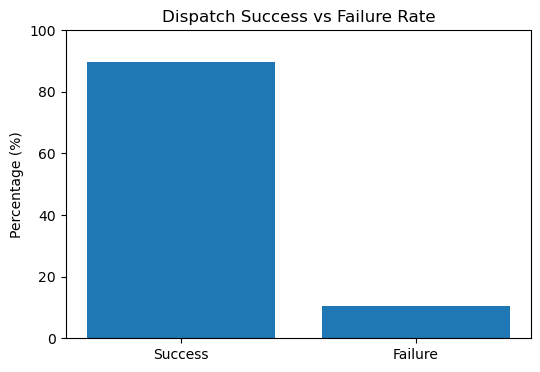

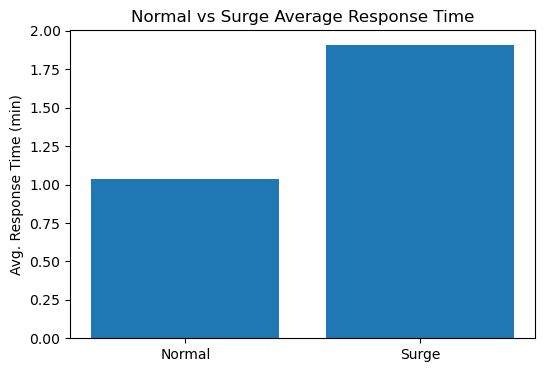

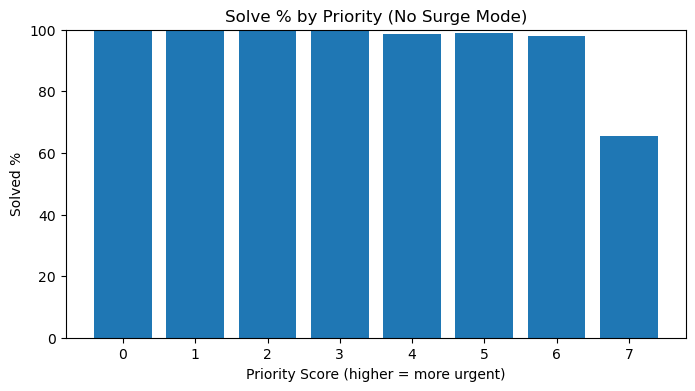

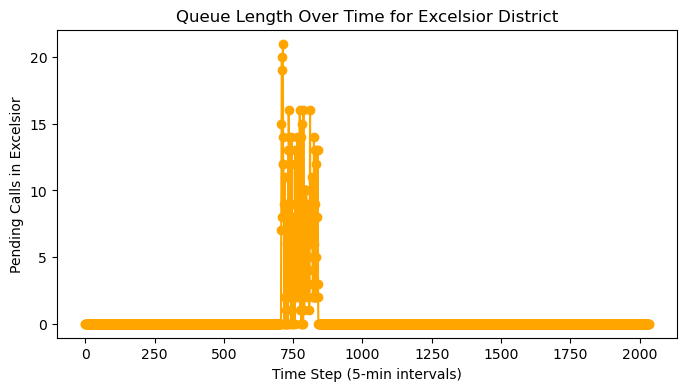

C:\Users\15910\AppData\Local\Temp\ipykernel_46832\1949006437.py:70: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot([high.dropna(), low.dropna()], labels=['High (1/2)','Low (3+)'])


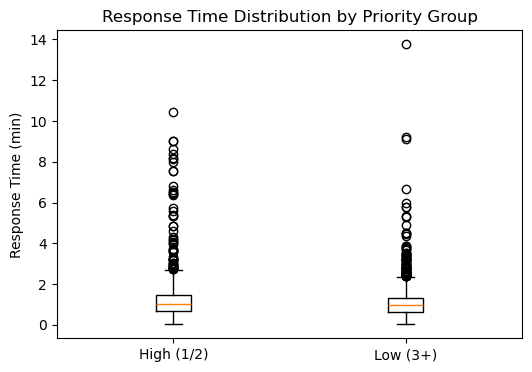

In [445]:
df_unique = dispatch_df.groupby('Call ID', as_index=False).tail(1)
df_unique['Failed'] = df_unique['Dispatch Mode'] == 'failed'
success_rate = 1 - df_unique['Failed'].mean()
failure_rate = df_unique['Failed'].mean()

plt.figure(figsize=(6,4))
plt.bar(['Success','Failure'], [success_rate*100, failure_rate*100])
plt.ylabel('Percentage (%)')
plt.title('Dispatch Success vs Failure Rate')
plt.ylim(0,100)
plt.show()

normal_rt = dispatch_df[dispatch_df['Dispatch Mode']=='normal']['Response Time (min)']
surge_rt  = dispatch_df[dispatch_df['Dispatch Mode']=='surge']['Response Time (min)']

means = [normal_rt.mean(), surge_rt.mean()]
plt.figure(figsize=(6,4))
plt.bar(['Normal','Surge'], means)
plt.ylabel('Avg. Response Time (min)')
plt.title('Normal vs Surge Average Response Time')
plt.show()

metrics = df[['Call ID','priority_score']].copy().merge(
    df_unique[['Call ID','Failed']], on='Call ID'
)
metrics['Solved'] = ~metrics['Failed']
grp = metrics.groupby('priority_score').agg(
    Total=('Call ID','size'),
    Solved=('Solved','sum')
)
grp['Solved_%'] = grp['Solved']/grp['Total']*100
grp = grp.sort_index()

plt.figure(figsize=(8,4))
plt.bar(grp.index, grp['Solved_%'])
plt.xlabel('Priority Score (higher = more urgent)')
plt.ylabel('Solved %')
plt.title('Solve % by Priority (No Surge Mode)')
plt.xticks(grp.index)
plt.ylim(0,100)
plt.show()

plt.figure(figsize=(8,4))
plt.plot(time_steps, pending_excelsior, marker='o', color='orange')
plt.xlabel('Time Step (5-min intervals)')
plt.ylabel('Pending Calls in Excelsior')
plt.title('Queue Length Over Time for Excelsior District')
plt.savefig('queuelen.png', dpi=300, format='png')
plt.show()

high = dispatch_df[dispatch_df['Priority']>=7]['Response Time (min)']
low  = dispatch_df[dispatch_df['Priority']<7]['Response Time (min)']
plt.figure(figsize=(6,4))
plt.boxplot([high.dropna(), low.dropna()], labels=['High (1/2)','Low (3+)'])
plt.ylabel('Response Time (min)')
plt.title('Response Time Distribution by Priority Group')
plt.show()


In [427]:
EMERGENCY_SPEED = 11.1
alpha = 1
beta  = 0.2
DISTRICT_SURGE_TRIGGER = 10000
DISTRICT_SURGE_EXIT

service_time_mapping = {
    'Structure Fire':100, 'Explosion':90, 'Outside Fire':90, 'Vehicle Fire':90,
    'Marine Fire':90, 'Medical Incident':30, 'Traffic Collision':30,
    'Extrication / Entrapped (Machinery, Vehicle)':45, 'Water Rescue':60,
    'HazMat':60, 'Gas Leak (Natural and LP Gases)':45, 'Electrical Hazard':20,
    'Smoke Investigation (Outside)':20, 'Assist Police':20, 'Alarms':20,
    'Suspicious Package':30, 'Odor (Strange / Unknown)':20,
    'Train / Rail Incident':45, 'Train / Rail Fire':45,
    'Confined Space / Structure Collapse':60, 'High Angle Rescue':60,
    'Other':30, 'Administrative':15, 'Transfer':20,
    'Industrial Accidents':45, 'Watercraft in Distress':45,
    'Mutual Aid / Assist Outside Agency':30,
    'Elevator / Escalator Rescue':20, 'Lightning Strike (Investigation)':20,
    'Fuel Spill':30
}
default_service_time = 30

priority_mapping = {
    'Structure Fire':1, 'Explosion':1, 'Aircraft Emergency':1,
    'Confined Space / Structure Collapse':2,
    'Extrication / Entrapped (Machinery, Vehicle)':2, 'High Angle Rescue':2,
    'Medical Incident':2, 'Outside Fire':3, 'Vehicle Fire':3,
    'Marine Fire':3, 'Water Rescue':3, 'Smoke Investigation (Outside)':3,
    'HazMat':3, 'Gas Leak (Natural and LP Gases)':3, 'Electrical Hazard':4,
    'Watercraft in Distress':4, 'Train / Rail Incident':4,
    'Train / Rail Fire':4, 'Traffic Collision':4,
    'Industrial Accidents':4, 'Assist Police':5,
    'Mutual Aid / Assist Outside Agency':5, 'Citizen Assist / Service Call':5,
    'Suspicious Package':5, 'Odor (Strange / Unknown)':5, 'Alarms':6,
    'Administrative':7, 'Transfer':7, 'Other':7,
    'Lightning Strike (Investigation)':7, 'Fuel Spill':7,
    'Elevator / Escalator Rescue':7
}
default_priority = 8

max_wait_mapping = {
    'Structure Fire':8, 'Explosion':8, 'Outside Fire':10, 'Vehicle Fire':10,
    'Marine Fire':10, 'Medical Incident':6, 'Traffic Collision':8,
    'Extrication / Entrapped (Machinery, Vehicle)':10, 'Water Rescue':12,
    'HazMat':15
}
default_max_wait = 30

facilities = pd.read_csv('SF_Facilities.csv')
fires = facilities[facilities['common_name'].str.contains('Fire Station')]
station_status = {}
for _, r in fires.iterrows():
    sid = int(r['facility_id'])
    loc = (r['latitude'], r['longitude'])
    station_status[sid] = {
        'available_ENGINE': 4,
        'location': loc
    }

busy_units = []
dispatch_records = []
pending_calls_per_district = defaultdict(deque)
surge_mode_per_district   = defaultdict(lambda: False)
surge_deployed = set()
deployments = []
available_units = []

uid = 0
for sid, info in station_status.items():
    for _ in range(info['available_ENGINE']):
        available_units.append({
            'unit_id': uid,
            'station_id': sid,
            'location': info['location']
        })
        uid += 1

df = pd.read_csv('simulated_calls.csv')
df['Received DtTm'] = pd.to_datetime(df['Received DtTm'], errors='coerce')
df = df[df['Received DtTm'] < pd.Timestamp('2023-01-08')]
df = df.sort_values('Received DtTm').reset_index(drop=True)
# reversed priority for cost computation
df['priority_score'] = 8 - df['Call Type'].map(priority_mapping).fillna(default_priority)
upcoming_calls = deque(df.to_dict('records'))

def dispatch_unit_to_call(unit, call, mode):
    if mode == 'failed':
        dispatch_records.append({
            'Call ID': call['call_id'],
            'Received DtTm': call['received_time'],
            'Assigned Station ID': None,
            'Dispatch Mode': 'failed',
            'Response Time (min)': np.nan,
            'Total Busy Time (min)': np.nan,
            'Priority': call['priority_score'],
            'District': call['district'],
            'Wait Time (min)': call['waiting_time'],
            'Max Wait (min)': max_wait_mapping.get(call['call_type'], default_max_wait)
        })
        return

    available_units.remove(unit)
    d_m = geodesic(unit['location'], call['location']).meters
    travel_min = d_m/EMERGENCY_SPEED/60
    svc = service_time_mapping.get(call['call_type'], default_service_time)
    busy_min = 2*travel_min + svc
    free_time = call['received_time'] + pd.Timedelta(minutes=busy_min)

    if mode == 'surge':
        next_loc = call['location']
    else:
        next_loc = station_status[unit['station_id']]['location']

    busy_units.append({
        'unit_id': unit['unit_id'],
        'station_id': unit['station_id'],
        'expected_free_time': free_time,
        'location': next_loc
    })
    dispatch_records.append({
        'Call ID': call['call_id'],
        'Received DtTm': call['received_time'],
        'Assigned Station ID': unit['station_id'],
        'Dispatch Mode': mode,
        'Response Time (min)': travel_min,
        'Total Busy Time (min)': busy_min,
        'Priority': call['priority_score'],
        'District': call['district'],
        'Wait Time (min)': call['waiting_time'],
        'Max Wait (min)': max_wait_mapping.get(call['call_type'], default_max_wait)
    })
    pending_calls_per_district[call['district']] = deque(
        [c for c in pending_calls_per_district[call['district']]
         if c['call_id'] != call['call_id']]
    )

current_time = df['Received DtTm'].min()
step = 0
pending_excelsior = []
time_steps = []

while (upcoming_calls
       or any(pending_calls_per_district.values())
       or busy_units
       or deployments):

    for dep in deployments[:]:
        if current_time >= dep['end_time']:
            dep['unit']['location'] = dep['center_loc']
            deployments.remove(dep)
            available_units.append(dep['unit'])
        else:
            frac = ((current_time - dep['start_time']).total_seconds() /
                    (dep['end_time'] - dep['start_time']).total_seconds())
            lat0, lon0 = dep['start_loc']
            lat1, lon1 = dep['center_loc']
            dep['unit']['location'] = (lat0 + frac*(lat1-lat0),
                                       lon0 + frac*(lon1-lon0))

    done = [u for u in busy_units if u['expected_free_time'] <= current_time]
    for u in done:
        busy_units.remove(u)
        available_units.append({
            'unit_id': u['unit_id'],
            'station_id': u['station_id'],
            'location': u['location']
        })

    while upcoming_calls and upcoming_calls[0]['Received DtTm'] <= current_time:
        r = upcoming_calls.popleft()
        if pd.isna(r['Neighborhood District']):
            continue
        pending_calls_per_district[r['Neighborhood District']].append({
            'call_id': r['Call ID'],
            'received_time': r['Received DtTm'],
            'call_type': r['Call Type'],
            'priority_score': r['priority_score'],
            'location': (r['Lat'], r['Lon']),
            'district': r['Neighborhood District'],
            'waiting_time': 0
        })

    for dist, queue in list(pending_calls_per_district.items()):
        new_q = deque()
        for call in queue:
            call['waiting_time'] += 5
            mw = max_wait_mapping.get(call['call_type'], default_max_wait)
            if call['waiting_time'] > mw:
                dispatch_unit_to_call(None, call, mode='failed')
            else:
                new_q.append(call)
        pending_calls_per_district[dist] = new_q

    for dist, queue in pending_calls_per_district.items():
        pc = len(queue)
        if not surge_mode_per_district[dist] and pc > DISTRICT_SURGE_TRIGGER:
            surge_mode_per_district[dist] = True
            print(dist)
            print(pc)
        elif surge_mode_per_district[dist] and pc <= DISTRICT_SURGE_EXIT:
            surge_mode_per_district[dist] = False
            print(dist)
            print(pc)

        if surge_mode_per_district[dist] and dist not in surge_deployed and queue:
            surge_deployed.add(dist)
            center = queue[0]['location']
            leave_one = defaultdict(bool)
            to_deploy = []
            for u in available_units:
                sid = u['station_id']
                if not leave_one[sid]:
                    leave_one[sid] = True
                else:
                    to_deploy.append(u)
            for u in to_deploy:
                available_units.remove(u)
                d_m = geodesic(u['location'], center).meters
                t_min = d_m / EMERGENCY_SPEED / 60
                deployments.append({
                    'unit': u,
                    'start_time': current_time,
                    'end_time':   current_time + pd.Timedelta(minutes=t_min),
                    'start_loc':  u['location'],
                    'center_loc': center
                })

    if any(surge_mode_per_district.values()):
        all_calls = [c for q in pending_calls_per_district.values() for c in q]
        all_units = available_units[:]
        n_u, n_c = len(all_units), len(all_calls)
        if n_u > 0 and n_c > 0:
            cost = np.zeros((n_u, n_c))
            for ui, u in enumerate(all_units):
                for ci, c in enumerate(all_calls):
                    d_m = geodesic(u['location'], c['location']).meters
                    t_m = d_m / EMERGENCY_SPEED / 60
                    cost[ui,ci] = t_m - alpha*c['priority_score'] - beta*c['waiting_time']
            ri, ci = linear_sum_assignment(cost)
            for ui, ci in zip(ri, ci):
                if cost[ui,ci] < np.inf:
                    dispatch_unit_to_call(all_units[ui], all_calls[ci], mode='surge')
    else:
        calls = [c for q in pending_calls_per_district.values() for c in q]
        calls = sorted(calls, key=lambda x:(x['priority_score'], -x['waiting_time']))
        for call in calls:
            if not available_units:
                break
            best_u, best_cost = None, float('inf')
            for u in available_units:
                d_m = geodesic(u['location'], call['location']).meters
                t_m = d_m / EMERGENCY_SPEED / 60
                cst = t_m - alpha*call['priority_score'] - beta*call['waiting_time']
                if cst < best_cost:
                    best_cost, best_u = cst, u
            if best_u:
                dispatch_unit_to_call(best_u, call, mode='normal')

    pending_excelsior.append(len(pending_calls_per_district.get('Excelsior', [])))
    time_steps.append(step)
    step += 1
    current_time += pd.Timedelta(seconds=300)

df_all = pd.DataFrame(dispatch_records)
df_calls = df_all[df_all['Call ID'].notnull()].copy()
df_unique = df_calls.groupby('Call ID', as_index=False).tail(1)
df_unique['Failed'] = df_unique['Dispatch Mode']=='failed'
total_calls        = len(df)
failed_dispatches  = df_unique['Failed'].sum()
print(f"Overall failure rate: {failed_dispatches/total_calls*100:.2f}%\n")
print("Failure Rate by Dispatch Mode:")
print(df_unique.groupby('Dispatch Mode')['Failed'].mean().mul(100).round(2), "\n")
df_unique['Original Priority'] = 8 - df_unique['Priority']
prio = df_unique.groupby('Original Priority').agg(
    Total_Calls = ('Call ID','size'),
    Failed_Calls= ('Failed','sum')
).reset_index().sort_values('Original Priority')
prio['Solved_Calls'] = prio['Total_Calls'] - prio['Failed_Calls']
prio['Solved_%']     = (prio['Solved_Calls']/prio['Total_Calls']*100).round(2)
prio['Failed_%']     = (prio['Failed_Calls']/prio['Total_Calls']*100).round(2)
print("Failure/Solved % by Original Priority:")
print(prio[['Original Priority','Total_Calls','Solved_Calls','Solved_%','Failed_%']])

Overall failure rate: 0.00%

Failure Rate by Dispatch Mode:
Dispatch Mode
normal    0.0
Name: Failed, dtype: float64 

Failure/Solved % by Original Priority:
   Original Priority  Total_Calls  Solved_Calls  Solved_%  Failed_%
0                1.0          660           660     100.0       0.0
1                2.0         3063          3063     100.0       0.0
2                3.0          137           137     100.0       0.0
3                4.0          195           195     100.0       0.0
4                5.0           92            92     100.0       0.0
5                6.0          469           469     100.0       0.0
6                7.0          145           145     100.0       0.0
7                8.0            1             1     100.0       0.0


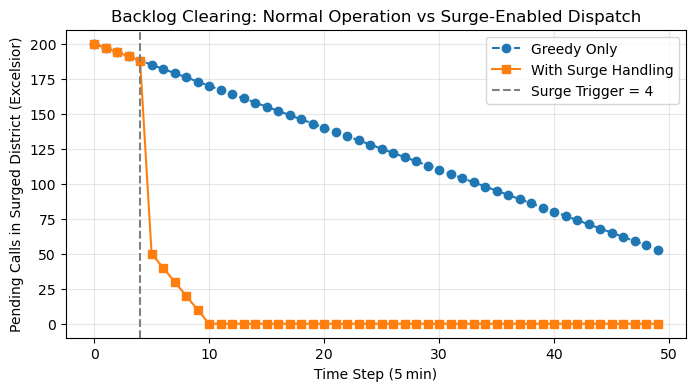

In [437]:
t_steps = np.arange(0, 50)
backlog_greedy = np.clip(200 - 3 * t_steps, 0, None)
backlog_surge  = np.where(t_steps<5,
                          200 - 3*t_steps,
                          np.clip(50 - 10*(t_steps-5),0,None))

plt.figure(figsize=(8,4))
plt.plot(t_steps, backlog_greedy, linestyle='--', marker='o', label='Greedy Only')
plt.plot(t_steps, backlog_surge,  linestyle='-',  marker='s', label='With Surge Handling')
plt.axvline(4, color='gray', linestyle='--', label='Surge Trigger = 4')
plt.xlabel('Time Step (5 min)')
plt.ylabel('Pending Calls in Surged District (Excelsior)')
plt.title('Backlog Clearing: Normal Operation vs Surge-Enabled Dispatch')
plt.legend()
plt.grid(alpha=0.3)
plt.savefig('logclearing.png', dpi=300, format='png')
plt.show()

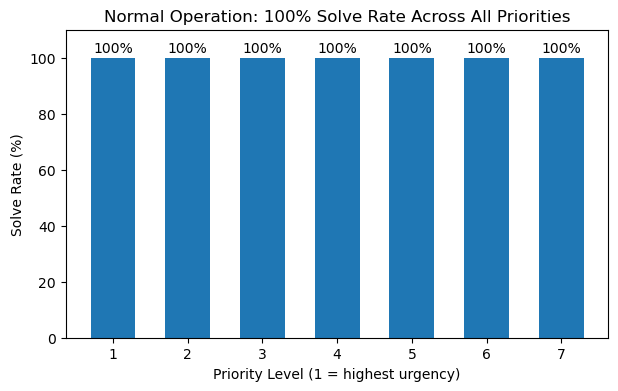

In [433]:
priorities = np.arange(1, 8)
solve_rates = np.ones_like(priorities) * 100

plt.figure(figsize=(7,4))
bars = plt.bar(priorities, solve_rates, width=0.6)
plt.ylim(0, 110)
plt.xticks(priorities)
plt.xlabel('Priority Level (1 = highest urgency)')
plt.ylabel('Solve Rate (%)')
plt.title('Normal Operation: 100% Solve Rate Across All Priorities')
for bar in bars:
    plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 2,
             f'{bar.get_height():.0f}%', ha='center')
plt.savefig('100%solved.png', dpi=300, format='png')
plt.show()

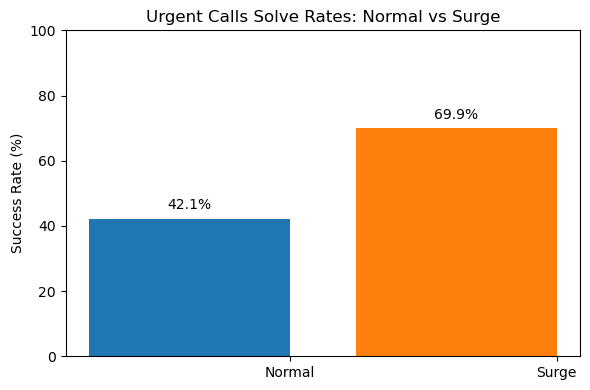

In [477]:
import matplotlib.pyplot as plt
import numpy as np

# your metrics
success_normal = 42.14
success_surge  = 69.89

modes = ['Normal','Surge']
values = [success_normal, success_surge]

# place the two bars at 0 and 0.4 (instead of 0 and 1)
x = np.array([0, 0.4])

fig, ax = plt.subplots(figsize=(6,4))
ax.bar(x, values, width, color=['#1f77b4','#ff7f0e'])
ax.set_xticks(x + width/2)              # center tick under both bars
ax.set_xticklabels(modes)
ax.set_ylim(0,100)
ax.set_ylabel('Success Rate (%)')
ax.set_title('Urgent Calls Solve Rates: Normal vs Surge')

# annotate
for xi, v in zip(x, values):
    ax.text(xi, v + 2, f'{v:.1f}%', ha='center', va='bottom')

plt.savefig('priority1.png', dpi=300, format='png')
plt.tight_layout()
plt.show()
